**Work in progress, but workable already**

Check the _1. Simple query.ipynb_ notebook for details on how to get data from the 24SEA API.


In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
%config InteractiveShell.ast_node_interactivity = 'all'

In [ ]:
# **Package Imports**
# - From the Python Standard Library
import logging
import os
import sys

# - From third party libraries
import api_24sea
import dotenv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import py_fatigue as pf
import rich
from py_fatigue.damage import crack_growth
from py_fatigue.geometry import InfiniteSurface, HollowCylinder
from py_fatigue.material import ParisCurve
from api_24sea.datasignals import fatigue


In [ ]:
# - Some plot settings
plt.rcParams["figure.figsize"] = (10.5 / 2.514 / 0.7, 7.5 / 2.514 / 0.7)
plt.rcParams["font.family"] = "monospace"
plt.rcParams["font.size"] = 9
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.color"] = "#DDDDDD"
plt.rcParams["grid.linestyle"] = "-"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["lines.markersize"] = 3
plt.rcParams["xtick.bottom"] = False
plt.rcParams["xtick.labelbottom"] = True
plt.rcParams["ytick.left"] = False
plt.rcParams["ytick.labelleft"] = True
plt.rcParams["figure.facecolor"] = "none"
plt.rcParams["axes.facecolor"] = "none"
plt.rcParams["figure.facecolor"] = "none"
plt.rcParams["axes.facecolor"] = "none"
plt.rcParams["savefig.facecolor"] = "none"
plt.rcParams["axes.labelcolor"] = "#333333"
plt.rcParams["lines.linewidth"] = 0.5
plt.rcParams["lines.markeredgewidth"] = 0.5
plt.rcParams["lines.markersize"] = 2
plt.rcParams["axes.prop_cycle"] = plt.cycler(
    color=["lightseagreen", "orchid", "gold", "orangered", "royalblue",
           "slategrey", "teal", "darkkhaki", "lightcoral", "yellowgreen"]
)


In [ ]:
# **Package Versions**
print(f"📂 \033[1m\033[93mWorking Folder:     \033[0;34;4m{os.getcwd()}\033[0m")
print(f"🐼 \033[1m\033[93mPandas Version:     \033[0;3m{pd.__version__}\033[0m")
print(f"⚡  \033[1m\033[93mSwifter Version:    \033[0;3m{fatigue.S.swifter.__version__}\033[0m")
print(f"💪 \033[1m\033[93mPy-fatigue Version: \033[0;3m{fatigue.S.py_fatigue.__version__}\033[0m")
print(f"🌊 \033[1m\033[93mApi-24SEA Version:  \033[0;3m{api_24sea.__version__}\033[0m")
print(f"🐍 \033[1m\033[93mPython Version:     \033[0;3m{sys.version}\033[0m")
# **Notebook Configuration**
logger = logging.getLogger()
logger.setLevel(logging.INFO)


In [ ]:
# **Load Environment Variables from .env File**
_ = dotenv.load_dotenv("variables.env")
if _:
    print("Environment Variables Loaded Successfully")
    print(os.getenv("API_24SEA_USERNAME"))
    # print(os.getenv("24SEA_API_PASSWORD"))
else:
    raise Exception("Environment Variables Not Loaded")


In [ ]:
# **Metrics Overview**
# The metrics overview is a summary of the metrics available in the API.
df = pd.DataFrame()
m_o = df.datasignals._DataSignals__api.metrics_overview
m_o.head(10)


#### Data retrieval step


In [ ]:
# **Data Retrieval**

sites = ["windfarm"]

locations = m_o[m_o["site"].str.lower() == sites[0]]["location"].unique().tolist()

metrics = ["cc", "dem"]

# start_timestamp = "2024-01-01T00:00:00Z"
# end_timestamp = "2025-01-01T01:00:00Z"
# See https://pypi.org/project/shorthand-datetime package for more information
# on how to use shorthand datetime strings to set start and end timestamps.
start_timestamp = "now-1d/d"
end_timestamp = "now/d"

df.datasignals.get_data(
    sites, locations, metrics, start_timestamp, end_timestamp
)

In [ ]:

# Count percentage  of none in each column
none_perc_dict = {}
for col in df.columns:
    none_perc_dict[col] = f"{round(df[col].isna().sum() / len(df) * 100, 2)}%"
    
rich.print_json(data=none_perc_dict)


## Py-fatigue interaction

The 10-minute cycle-count "matrices" (stored as dictionaries in the DataFrame) can be converted to `py-fatigue CycleCount` objects through the `fatigue` DataFrame accessor. This allows for easy access to the cycle-count data and the ability to perform cycle-count operations. The conversion happens inplace, so the original DataFrame is modified.


In [ ]:
df.fatigue.cycle_counts_to_objects()
df.head()

## Hack

Since you want to kep the load sequence, although only within the 10-minute acquisitions, looping through every 10-minute acquisition and concatenating the cycle-counted stress ranges, cycles and residuals sequences allows for the creation of a single cycle-counted stress range, cycle and residual sequence where the load sequence is preserved.


CC_ CC_BB_C01_TP_SG_LAT019_DEG025_0_nr1 (from 18 Feb 2025, 00:00 to 19 Feb 2025, 00:00)


,CC_BB_C01_TP_SG_LAT019_Mtn
Cycle counting object,
"largest full stress range, MPa",12.1915
"largest stress range, MPa",27.1441
number of full cycles,64250
number of residuals,1641
number of small cycles,0
stress concentration factor,N/A
residuals resolved,False
mean stress-corrected,No


(<Figure size 596.659x426.185 with 1 Axes>,
 <Axes: xlabel='Residuals sequence', ylabel='Residuals'>)

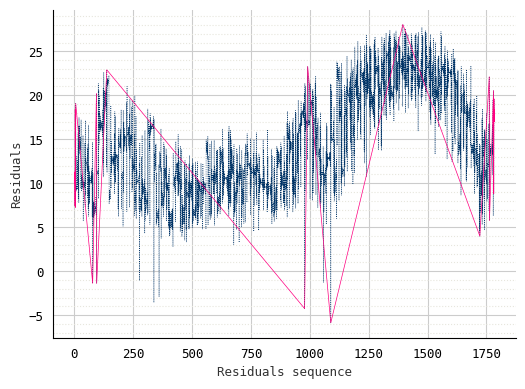

In [192]:
# For each column starting with CC_ in df, concatenate the stress_range and count_cycle arrays of every row
# into two very long arrays, and then plot the stress_range vs count_cycle as scatter plot.

cc_cols = [col for col in df.columns if col.startswith("CC_")]
from collections import defaultdict
# Initialize the defaultdict of dictionaries
cc_dict = defaultdict(lambda: defaultdict(list))
for col in cc_cols:
    cc_dict[col] = {
        'timestamp': [],
        'stress_range': [],
        'count_cycle': [],
        'residuals_sequence': []
    }

cycle_count_list = []
for col in cc_cols:
    for idx, row in df.dropna(how="all").iterrows():
        if row[col] is None:
            continue
        cc_dict[col]['timestamp'].extend([row.name])
        cc_dict[col]['stress_range'].extend(row[col].stress_range)
        cc_dict[col]['count_cycle'].extend(row[col].count_cycle)
        cc_dict[col]['residuals_sequence'].extend(row[col].residuals_sequence)

    if len(cc_dict[col]['stress_range']) == 0 or len(cc_dict[col]['count_cycle']) == 0:
        continue
    cycle_count_list.append(
        pf.CycleCount(
            name=col,
            stress_range=np.array(cc_dict[col]['stress_range']),
            count_cycle=np.array(cc_dict[col]['count_cycle']),
            mean_stress=np.zeros_like(cc_dict[col]['stress_range']),
            residuals_sequence=np.array(cc_dict[col]['residuals_sequence']),
            _time_sequence=np.array(cc_dict[col]['timestamp'])
        )
    )
print(cycle_count_list[0])

# Set cycle_count to the fore_aft bending moment column
cycle_count = cycle_count_list[-1]
cycle_count
cycle_count.plot_residuals_sequence()



## Paris Curve

The Paris curve is a mathematical model that describes the relationship between the rate of fatigue crack growth and the stress intensity factor range. The Paris curve is defined by the equation:

$$
\frac{da}{dN} = C(\Delta K)^m
$$

where:
- $\frac{da}{dN}$ is the rate of fatigue crack growth,
- $C$ is the material constant,
- $\Delta K$ is the stress intensity factor range,
- $m$ is the material constant.


[ 26.82695795  50.         223.60679775 562.34132519]


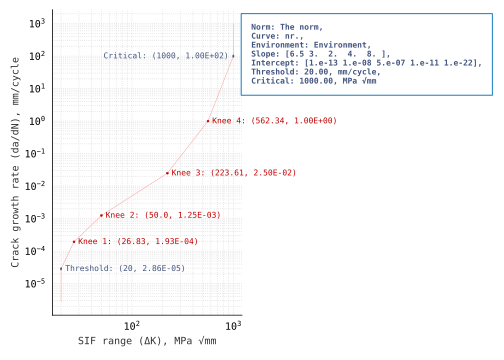

In [190]:
# **Paris Curve**

SIF = np.linspace(1, 2500, 300)
SLOPE = np.array([6.5, 3, 2, 4, 8])
INTER = np.array([1E-13, 1E-8, 5E-7, 1E-11, 1E-22])
THRESHOLD = 20
CRITICAL = 1000
pc = pf.ParisCurve(slope=SLOPE, intercept=INTER, threshold=THRESHOLD,
                   critical=CRITICAL, norm="The norm",
                   environment="Environment", curve="nr.")
# pc
print(pc.get_knee_sif())
pc

## Geometric properties of the crack

To perform an accuate crack length analysis, besides the crack growth curve, the geometric properties of the crack must be known, since the calculation of the stress intensity factor is affected by the crack geometry. (See [the py-fatigue user guide](https://owi-lab.github.io/py_fatigue/user/additional/glossary.html) for more information)

In [194]:
# Create a Geometry object

geo = InfiniteSurface(initial_depth=100)
geo


InfiniteSurface(
  _id=INF_SUR_00,
  initial_depth=100.0,
)

(<Figure size 596.659x426.185 with 1 Axes>, <Axes: >)

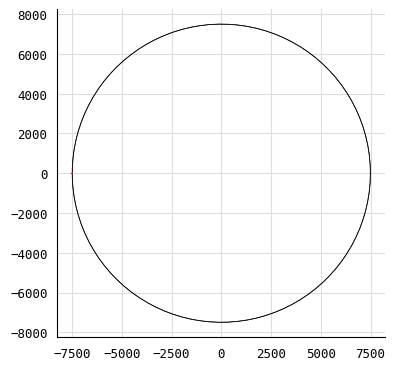

In [195]:
# Alternative Geometry (Hollow Cylinder)
geo = HollowCylinder(
  initial_depth=5.,
  thickness=10.,
  height=10,
  outer_diameter=15000.,
  crack_position="external"
)
geo.plot()


In [196]:
cg = pf.crack_growth.get_crack_growth(
  cycle_count, pc, geo, express_mode=True
)
print(f"Cycles to end: {int(cg.final_cycles)}")


Fatigue spectrum applied w/o failure. Stopping calculation
Cycles to end: 65070


Text(0.5, 0, 'Cumulative cycles')

Text(0, 0.5, 'Crack size, mm')

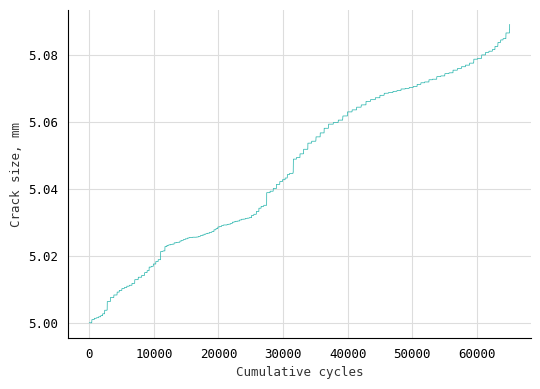

In [197]:
plt.plot(np.cumsum(cg.count_cycle), cg.crack_depth)
plt.xlabel("Cumulative cycles");
plt.ylabel("Crack size, mm");
plt.show()
